# Keras Sequential LSTM ANN for Market Trading

## <i> i.) Import Libraries and Dependencies </i>

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
import pandas_ta as ta

from matplotlib import pyplot as plt
from pathlib import Path
import os
import re

In [2]:
# Import Keras ANN Modeling Libraries & Sklearn Preprocessing Modules
from keras.models import Sequential, Model
from keras.layers import LSTM
from keras.layers import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.offsets import DateOffset

# Import Keras ANN Dropout & Regularizer Build Processing Modules
# Import dropout
from keras.layers import Dropout
# Import regularizers
from keras.regularizers import l1, l2

2022-12-05 18:22:44.301773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <i> ii.) Prepare the DataFrames </i>

In [3]:
# Get filename from dir and store as 'algoData_asset' for each individual asset file to use later in labelling/filenaming
filename = Path("../Datasets/algoData_S&P500.csv")

display(os.path.basename(filename))
display(os.path.dirname(filename))
display(os.path.splitext(filename))
display(os.path.splitext(os.path.basename(filename)))
algoData_asset = os.path.splitext(os.path.basename(filename))
algoData_asset = algoData_asset[0] 
algoData_asset = algoData_asset.split('_')
algoData_asset = algoData_asset[1]
print(algoData_asset)

#print(os.path.splitext(filename))

'algoData_S&P500.csv'

'../Datasets'

('../Datasets/algoData_S&P500', '.csv')

('algoData_S&P500', '.csv')

S&P500


In [4]:
# Confirm algoData_asset is type(str)
type(algoData_asset)

str

In [5]:
#Import .csv file as dataframe and shift 'ActualReturns' column forward .shift() 
#to re-align to neutral (as the 'Signal' column and 'ActualReturns' are both shifted backed (.shift(-1)) in the raw .csv file

# Import filename & conver to dataframe
df = pd.read_csv(filename, 
                index_col='Date', 
                parse_dates=True,
                infer_datetime_format=True)
display(df.head(3))
display(df.tail(3))

# Create empty dataframe for 'ActualReturns' column and shift(+1) to realign to neutral timeseries index position
actual_returns_shift_df = pd.DataFrame()
actual_returns_shift_df['Norm Actual Returns'] = df['ActualReturns'].shift()

,Ticker,Date.1,Open,High,Low,Close,Volume,ActualReturns,Signal,EMAShort,...,MOMline_normal,ROCline_normal,SMAline_normal,lowerBB_normal,middleBB_normal,upperBB_normal,2stdBB_normal,MACDline_normal,MACDHistogram_normal,MACDSignal_normal
Date,,,,,,,,,,,,,,,,,,,,,
2006-10-23 00:00:00-04:00,S&P500,2006-10-23 00:00:00-04:00,1368.579956,1377.400024,1363.939941,1377.020020,2480430000,0.000261,1.0,1361.879276,...,7.326168,0.808229,2.205601,1.057307,1.026343,0.997142,0.004253,14.443024,0.524587,13.918438
2006-10-24 00:00:00-04:00,S&P500,2006-10-24 00:00:00-04:00,1377.020020,1377.780029,1372.420044,1377.380005,2876890000,0.003514,1.0,1364.264003,...,4.586124,0.648913,2.183401,1.056273,1.024972,0.995474,0.004303,14.609685,0.552998,14.056687
2006-10-25 00:00:00-04:00,S&P500,2006-10-25 00:00:00-04:00,1377.359985,1383.609985,1376.000000,1382.219971,2953540000,0.004963,1.0,1367.026460,...,4.767735,0.564316,1.932800,1.059152,1.026940,0.996630,0.004401,14.959862,0.722540,14.237322


,Ticker,Date.1,Open,High,Low,Close,Volume,ActualReturns,Signal,EMAShort,...,MOMline_normal,ROCline_normal,SMAline_normal,lowerBB_normal,middleBB_normal,upperBB_normal,2stdBB_normal,MACDline_normal,MACDHistogram_normal,MACDSignal_normal
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-26 00:00:00-04:00,S&P500,2022-10-26 00:00:00-04:00,3825.969971,3886.149902,3824.070068,3830.600098,4817310000,-0.006083,-1.0,3743.064400,...,8.289918,0.484020,-9.492002,1.085286,1.028940,0.978155,0.002711,-9.503818,34.608016,-44.111835
2022-10-27 00:00:00-04:00,S&P500,2022-10-27 00:00:00-04:00,3834.689941,3859.949951,3803.790039,3807.300049,4687320000,0.024626,1.0,3752.946808,...,16.903382,0.239292,-9.334800,1.076946,1.023543,0.975186,0.002605,-3.675620,32.348971,-36.024592
2022-10-28 00:00:00-04:00,S&P500,2022-10-28 00:00:00-04:00,3808.260010,3905.419922,3808.260010,3901.060059,4459410000,-0.007454,-1.0,3775.733462,...,28.599808,0.709188,-7.653604,1.104215,1.048489,0.998117,0.002587,8.411950,35.549233,-27.137283


In [6]:
actual_returns_shift_df = actual_returns_shift_df.dropna()

In [7]:
display(actual_returns_shift_df)

,Norm Actual Returns
Date,
2006-10-24 00:00:00-04:00,0.000261
2006-10-25 00:00:00-04:00,0.003514
2006-10-26 00:00:00-04:00,0.004963
2006-10-27 00:00:00-04:00,-0.008452
2006-10-30 00:00:00-05:00,0.000428
...,...
2022-10-24 00:00:00-04:00,0.011882
2022-10-25 00:00:00-04:00,0.016267
2022-10-26 00:00:00-04:00,-0.007388


In [8]:
# Create list for non-normalized columns to be dropped out if required
%pprint
col_names = list(df.columns.values)
display(col_names)
display(f"Number of unique columns: {len(col_names)}")

Pretty printing has been turned OFF


['Ticker', 'Date.1', 'Open', 'High', 'Low', 'Close', 'Volume', 'ActualReturns', 'Signal', 'EMAShort', 'EMALong', 'RSIline', 'MOMline', 'ROCline', 'SMAline', 'lowerBB', 'middleBB', 'upperBB', '2stdBB', 'MACDline', 'MACDHistogram', 'MACDSignal', 'EMAShort_zscore', 'EMALong_zscore', 'RSIline_zscore', 'MOMline_zscore', 'ROCline_zscore', 'SMAline_zscore', 'lowerBB_zscore', 'middleBB_zscore', 'upperBB_zscore', '2stdBB_zscore', 'MACDline_zscore', 'MACDHistogram_zscore', 'MACDSignal_zscore', 'EMAShort_normal', 'EMALong_normal', 'RSIline_normal', 'MOMline_normal', 'ROCline_normal', 'SMAline_normal', 'lowerBB_normal', 'middleBB_normal', 'upperBB_normal', '2stdBB_normal', 'MACDline_normal', 'MACDHistogram_normal', 'MACDSignal_normal']

'Number of unique columns: 48'

## <i> ii.) Split Data into Training & Test Sets for LSTM </i>

In [9]:
# Create X features dataframe for LSTM
# Drop non-normalized & pre-Zscore calculated column values
# Drop all Bear & Bull signals for Elder Ray as they do not apply to forex strategy only
# I.e. 'lowerBB_normal', 'middleBB_normal', 'upperBB_normal', '2stdBB_normal'

must_drop_feat = ['Ticker', 'Date.1']

OHLCV = ['Open', 'High', 'Low', 'Close', 'Volume'] 

standard_feat = ['EMAShort', 'EMALong', 'RSIline', 'MOMline', 'ROCline', 'SMAline', 'lowerBB', \
                 'middleBB', 'upperBB', '2stdBB', 'MACDline', 'MACDHistogram', 'MACDSignal']

normal_feat = ['EMAShort_normal', 'EMALong_normal', 'RSIline_normal', 'MOMline_normal', 'ROCline_normal', \
               'SMAline_normal', 'lowerBB_normal', 'middleBB_normal', 'upperBB_normal', \
               '2stdBB_normal', 'MACDline_normal', 'MACDHistogram_normal', 'MACDSignal_normal']

zscore_feat = ['EMAShort_zscore', 'EMALong_zscore', 'RSIline_zscore', 'MOMline_zscore', 'ROCline_zscore', \
               'SMAline_zscore', 'lowerBB_zscore', 'middleBB_zscore', 'upperBB_zscore', \
               '2stdBB_zscore', 'MACDline_zscore', 'MACDHistogram_zscore', 'MACDSignal_zscore']

oscillator_feat = ['RSIline', 'MOMline', 'ROCline','MACDline', 'MACDHistogram', 'MACDSignal']

oscillator_wo_RSI_feat = ['MOMline', 'ROCline','MACDline', 'MACDHistogram', 'MACDSignal']

# Choose backtest variable to be used later on to cut y_train & y_test prematurely
backcandles = 30

X = df.copy()
X = X.drop(columns = zscore_feat)
#X = X.drop(columns = standard_feat)
#X = X.drop(columns = OHLCV)
X = X.drop(columns = must_drop_feat)
#X = X.drop(columns = normal_feat)
#X = X.drop(columns = oscillator_feat)
X = X.drop(columns = oscillator_wo_RSI_feat)
X['ActualReturns'] = actual_returns_shift_df['Norm Actual Returns']
X = X.dropna()
#y = X[['Signal']]
X = X.drop(columns = ['Signal'])
X = X.drop(columns = ['Volume'])
X = X.drop(columns = ['SMAline'])

# Create target feature which is the difference between the open/close of the day and shifted back (-1) day(s) in order to predict
X['Target_Diff'] = X['Close'] - X['Open']
X['Target_Diff'] = X['Target_Diff'].shift(-1)

# Create feature target class that displays if close>open=1 & close<open=0 (1,0 for sigmoid compatibility)
X['Target_Class'] = [1 if X['Target_Diff'][i] > 0 else 0 for i in range(len(X))]

# Create feature target next close and shift back one day in order to predict for the next day
X['Target_Next_Close'] = X['Close'].shift(-1)

#X = X.reindex(columns=[0, 1, 2, 3, 'Target',])
X = X[['Open', 'High', 'Low', 'Close', 'RSIline', 'EMAShort', 'EMALong', 'Target_Diff', 'Target_Class', 'Target_Next_Close']]

# Set prediction column -> in this case try and predict buy/sell signal (1,0) with Target_Class
y = X[['Target_Class']]

display(f"Number of included columns in final X-features: {len(X.columns)}")
display(X)
display(y)

'Number of included columns in final X-features: 10'

,Open,High,Low,Close,RSIline,EMAShort,EMALong,Target_Diff,Target_Class,Target_Next_Close
Date,,,,,,,,,,
2006-10-24 00:00:00-04:00,1377.020020,1377.780029,1372.420044,1377.380005,75.281252,1364.264003,1349.654434,4.859985,1,1382.219971
2006-10-25 00:00:00-04:00,1377.359985,1383.609985,1376.000000,1382.219971,77.239463,1367.026460,1352.066696,6.869995,1,1389.079956
2006-10-26 00:00:00-04:00,1382.209961,1389.449951,1379.469971,1389.079956,79.694774,1370.419305,1354.808419,-11.550049,0,1377.339966
2006-10-27 00:00:00-04:00,1388.890015,1388.890015,1375.849976,1377.339966,66.477855,1371.484022,1356.477422,0.630005,1,1377.930054
2006-10-30 00:00:00-05:00,1377.300049,1381.219971,1373.459961,1377.930054,66.776108,1372.475720,1358.066506,0.009888,1,1377.939941
...,...,...,...,...,...,...,...,...,...,...
2022-10-24 00:00:00-04:00,3762.010010,3810.739990,3741.649902,3797.340088,54.033681,3703.155857,3737.302913,59.670166,1,3859.110107
2022-10-25 00:00:00-04:00,3799.439941,3862.850098,3799.439941,3859.110107,57.765246,3727.148819,3746.325668,4.630127,1,3830.600098
2022-10-26 00:00:00-04:00,3825.969971,3886.149902,3824.070068,3830.600098,55.524760,3743.064400,3752.568218,-27.389893,0,3807.300049


,Target_Class
Date,
2006-10-24 00:00:00-04:00,1
2006-10-25 00:00:00-04:00,1
2006-10-26 00:00:00-04:00,0
2006-10-27 00:00:00-04:00,1
2006-10-30 00:00:00-05:00,1
...,...
2022-10-24 00:00:00-04:00,1
2022-10-25 00:00:00-04:00,1
2022-10-26 00:00:00-04:00,0


In [10]:
# Splitting Datasets Using 145 Week Groupings
# Select trading begin
training_begin = X.index.min()
print(f"Training begin: {training_begin}.")

# Select trading end
# Note: months = 145 for all assets except ETH-USD (months= 14)
# Note: months = 145 for all assets except BTC-USD (months= 70)
training_end = X.index.min() + DateOffset(months = 145)
print(f"Training end: {training_end}.")

X_train = X.loc[training_begin:training_end] 
y_train_1 = y.loc[training_begin:training_end] 

X_test = X.loc[training_end:]
y_test_1 = y.loc[training_end:]

# Slice y_train & y_test by backcandle requirements
y_train = y_train_1.iloc[backcandles:]
y_test = y_test_1.iloc[backcandles:]

# Create Dataframe just to hold 'ActualReturns' values for end of calculations
X_ActualReturns = actual_returns_shift_df.loc[training_end:]
                
#Also save a second X_test_aligned_index for final dataframe
X_test_aligned_index = X.loc[training_end:]

Training begin: 2006-10-24 00:00:00-04:00.
Training end: 2018-11-24 00:00:00-04:00.


In [11]:
# Test output y_train
y_train

,Target_Class
Date,
2006-12-06 00:00:00-05:00,0
2006-12-07 00:00:00-05:00,1
2006-12-08 00:00:00-05:00,1
2006-12-11 00:00:00-05:00,0
2006-12-12 00:00:00-05:00,1
...,...
2018-11-16 00:00:00-05:00,0
2018-11-19 00:00:00-05:00,0
2018-11-20 00:00:00-05:00,0


In [12]:
#backcandles_offset_start_train = y_train.index.min() + DateOffset(days = backcandles)

#y_train = y_train.loc[backcandles_offset_start_train:]
#y_train

In [13]:
# y_test test
y_test

,Target_Class
Date,
2019-01-10 00:00:00-05:00,1
2019-01-11 00:00:00-05:00,1
2019-01-14 00:00:00-05:00,1
2019-01-15 00:00:00-05:00,1
2019-01-16 00:00:00-05:00,1
...,...
2022-10-24 00:00:00-04:00,1
2022-10-25 00:00:00-04:00,1
2022-10-26 00:00:00-04:00,0


In [14]:
X_test

,Open,High,Low,Close,RSIline,EMAShort,EMALong,Target_Diff,Target_Class,Target_Next_Close
Date,,,,,,,,,,
2018-11-26 00:00:00-05:00,2649.969971,2674.350098,2649.969971,2673.449951,42.470118,2692.234454,2724.365816,18.419922,1,2682.169922
2018-11-27 00:00:00-05:00,2663.750000,2682.530029,2655.889893,2682.169922,43.863468,2690.686064,2721.240194,52.340088,1,2743.790039
2018-11-28 00:00:00-05:00,2691.449951,2744.000000,2684.379883,2743.790039,52.599970,2698.855907,2722.910553,0.830078,1,2737.800049
2018-11-29 00:00:00-05:00,2736.969971,2753.750000,2722.939941,2737.800049,51.756738,2704.847313,2724.013479,22.409912,1,2760.169922
2018-11-30 00:00:00-05:00,2737.760010,2760.879883,2732.760010,2760.169922,54.678773,2713.358484,2726.691734,-0.129883,0,2790.370117
...,...,...,...,...,...,...,...,...,...,...
2022-10-24 00:00:00-04:00,3762.010010,3810.739990,3741.649902,3797.340088,54.033681,3703.155857,3737.302913,59.670166,1,3859.110107
2022-10-25 00:00:00-04:00,3799.439941,3862.850098,3799.439941,3859.110107,57.765246,3727.148819,3746.325668,4.630127,1,3830.600098
2022-10-26 00:00:00-04:00,3825.969971,3886.149902,3824.070068,3830.600098,55.524760,3743.064400,3752.568218,-27.389893,0,3807.300049


In [15]:
# Test output y_test
#backcandles_offset_start_test = y_test.index.min() + DateOffset(days = backcandles)

#y_test = y_test.loc[backcandles_offset_start_test:]

In [16]:
#y_test

In [17]:
# Function to convert all sell signals (-1) to be compatible with the output sigmoid activation function

#def convert_neg(y_df):
#    for i in (range(len(y_df))):
#        if (y_df['Signal'][i] == -1):
#            y_df['Signal'][i] = 0
#        
#    return y_df

In [18]:
#y_train.copy()
#y_train = convert_neg(y_train)

In [19]:
#y_test.copy()
#y_test = convert_neg(y_test)

In [20]:
# Re-test output y_train after -1->0 conversion for sigmoid output compatiblity 
#y_train

In [21]:
# Re-test output y_test after -1->0 conversion for sigmoid output compatiblity 
#y_test

In [22]:
# Training & Test Set Dimensions

display(f"X Dataframe shape: {X.shape}.")
display(f"y Dataframe shape: {y.shape}.")
display(f"X_train Dataframe shape: {X_train.shape}.")
display(f"y_train shape: {y_train.shape}.")
display(f"X_test Dataframe shape: {X_test.shape}.")
display(f"y_test shape: {y_test.shape}.")

'X Dataframe shape: (4032, 10).'

'y Dataframe shape: (4032, 1).'

'X_train Dataframe shape: (3043, 10).'

'y_train shape: (3013, 1).'

'X_test Dataframe shape: (989, 10).'

'y_test shape: (959, 1).'

In [23]:
# Convert y_train/y_test dataframe ['Target_Class'] columns values to array for Keras Sequential fitting 

y_train = y_train['Target_Class'].values
display(y_train[0:3])
display(y_train[-1])
y_test = y_test['Target_Class'].values
display(y_test[0:3])
display(y_test[-1])

array([0, 1, 1])

1

array([1, 1, 1])

0

In [24]:
# Finalize the y_train & y_test data into a trainable array
# Reshape into vertical vectors for use in Sequential Model algorithm

#y_train = y_train['Signal'].values.astype("int32")
#y_train = y_train.reshape(-1,1).astype("int32")
y_train = y_train.reshape(-1,1).astype("int32")

#y_test = y_test['Signal'].values.astype("int32")
y_test = y_test.reshape(-1,1).astype("int32")


display((f"Number of final X_test features to run into ANN: {len(X_test.columns)}."))
display(y_train[0:10])
display(y_test[0:10])

'Number of final X_test features to run into ANN: 10.'

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0]], dtype=int32)

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1]], dtype=int32)

In [25]:
# Create the StandardScaler instance
X_scaler = MinMaxScaler(feature_range=(0,1))
#X_train_scaled = pd.DataFrame(X_scaler.fit_transform(X_train),columns =X_train.columns)
#X_test_scaled = pd.DataFrame(X_scaler.fit_transform(X_test),columns =X_test.columns)

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Display X_train_scaled & X_test_scaled shapes
display(f"X_train_scaled shape: {X_train_scaled.shape}")
display(f"X_train_scaled shape: {X_test_scaled.shape}")

'X_train_scaled shape: (3043, 10)'

'X_train_scaled shape: (989, 10)'

In [26]:
(X_test_scaled.shape[1]-3)

7

In [27]:
X_test_scaled.shape[0]

989

In [28]:
# Backtesting Setup for Training Data
# x = list of the number of features to be provided from the data to the model
x_train_scaled = []

# Setting backcandles for backtesting/short-term memory recursive setup
# Backcandles 10 candles (closing prices) back in time to predict the next days
# where j = number of X features to be included in test
# where i = number the backcandles grouping represents through all index rows 
print(f'X_train_scaled shape: {X_train_scaled.shape[0]}.')
for j in range((X_train_scaled.shape[1]-3)): # range is the number of input columns counting from 1->j[-1], i.e in this case range = 11
    x_train_scaled.append([])
    for i in range(backcandles, X_train_scaled.shape[0]):
        x_train_scaled[j].append(X_train_scaled[i-backcandles:i,j])
        
x_train_scaled=np.moveaxis(x_train_scaled, [0], [2])

x_train_scaled = np.array(x_train_scaled)

print()
print("'X_train_scaled' --> transformed into 'x_trained_scaled' ")
print(f'x_trained_scaled shape: {x_train_scaled.shape}')
print(f'y_train shape: {y_train.shape}')

X_train_scaled shape: 3043.

'X_train_scaled' --> transformed into 'x_trained_scaled' 
x_trained_scaled shape: (3013, 30, 7)
y_train shape: (3013, 1)


In [29]:
# Backtesting Setup for Testing Data
# x = list of the number of features to be provided from the data to the model
x_test_scaled = []

# Setting backcandles for backtesting/short-term memory recursive setup
# Backcandles 10 candles (closing prices) back in time to predict the next days
# where j = number of X features to be included in test
# where i = number the backcandles grouping represents through all index rows 
print(X_test_scaled.shape[0])
for j in range((X_test_scaled.shape[1]-3)): # range is the number of input columns counting from 1->j[-1], i.e in this case range = 11
    x_test_scaled.append([])
    for i in range(backcandles, X_test_scaled.shape[0]):
        x_test_scaled[j].append(X_test_scaled[i-backcandles:i,j])
        
x_test_scaled=np.moveaxis(x_test_scaled, [0], [2])

x_test_scaled = np.array(x_test_scaled)

print()
print("'X_test_scaled' --> transformed into 'x_test_scaled' ")
print(f'x_test_scaled shape: {x_test_scaled.shape}')
print(f'y_test_scaled shape: {y_test.shape}')

989

'X_test_scaled' --> transformed into 'x_test_scaled' 
x_test_scaled shape: (959, 30, 7)
y_test_scaled shape: (959, 1)


## <i> iii.) Constructing the LSTM Model Using Sequential Model & LSTM Module</i>

### <i> Defining the Input Parameters, Compile & Fit LSTM: </i>

In [44]:
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

# Define LSTM Input Parameters
lstm_input = Input(shape=(backcandles, (X_test_scaled.shape[1]-3)), name='lstm_input')
inputs = LSTM(100, name='first_layer')(lstm_input)

# Define Standard Hidden Layers 
inputs = Dense(1, name='dense_layer')(inputs)

# Define Output Layers
output = Activation('linear', name='output')(inputs)

# Define/Construct Model
nn = Model(inputs=lstm_input, outputs=output)

# Instantiate the Adam Optimizer
adam = optimizers.Adam()

# Summary Statistics of the LSTM 
nn.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 30, 7)]           0         
                                                                 
 first_layer (LSTM)          (None, 100)               43200     
                                                                 
 dense_layer (Dense)         (None, 1)                 101       
                                                                 
 output (Activation)         (None, 1)                 0         
                                                                 
Total params: 43,301
Trainable params: 43,301
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Compile Model
nn.compile(optimizer=adam, loss='mse', metrics=["accuracy"])

# Fit the LSTM
print("Fit model on X_train_scaled data")                                                  
fit_model = nn.fit(x=x_train_scaled, y=y_train, batch_size=64, epochs=50, shuffle=True, verbose=2)

Fit model on X_train_scaled data
Epoch 1/50
48/48 - 3s - loss: 0.2813 - accuracy: 0.4905 - 3s/epoch - 71ms/step
Epoch 2/50
48/48 - 1s - loss: 0.2546 - accuracy: 0.5134 - 1s/epoch - 26ms/step
Epoch 3/50
48/48 - 1s - loss: 0.2522 - accuracy: 0.5095 - 1s/epoch - 26ms/step
Epoch 4/50
48/48 - 1s - loss: 0.2503 - accuracy: 0.5214 - 1s/epoch - 27ms/step
Epoch 5/50
48/48 - 1s - loss: 0.2522 - accuracy: 0.5138 - 1s/epoch - 28ms/step
Epoch 6/50
48/48 - 1s - loss: 0.2502 - accuracy: 0.5324 - 1s/epoch - 29ms/step
Epoch 7/50
48/48 - 1s - loss: 0.2515 - accuracy: 0.5068 - 1s/epoch - 27ms/step
Epoch 8/50
48/48 - 1s - loss: 0.2511 - accuracy: 0.5284 - 1s/epoch - 27ms/step
Epoch 9/50
48/48 - 1s - loss: 0.2502 - accuracy: 0.5231 - 1s/epoch - 27ms/step
Epoch 10/50
48/48 - 1s - loss: 0.2515 - accuracy: 0.5141 - 1s/epoch - 27ms/step
Epoch 11/50
48/48 - 1s - loss: 0.2514 - accuracy: 0.5191 - 1s/epoch - 29ms/step
Epoch 12/50
48/48 - 1s - loss: 0.2508 - accuracy: 0.5261 - 1s/epoch - 26ms/step
Epoch 13/50
48/4

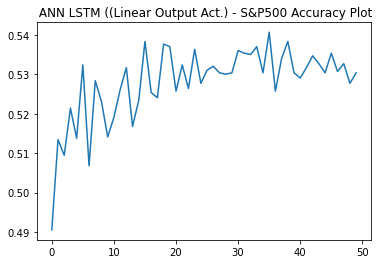

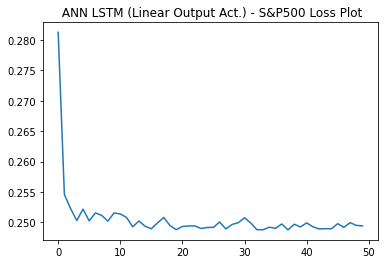

In [46]:
# Plot the Output of the fit_model history
fig, ax = plt.subplots(1) # Creates figure fig and add an axes, ax.
fig2, ax2 = plt.subplots(1) # Another figure

ax.set_title(f' ANN LSTM ((Linear Output Act.) - {algoData_asset} Accuracy Plot')
ax.plot(fit_model.history['accuracy'], label='train')
fig.savefig(f'../Datasets/algoData_LSTM_results/{algoData_asset}_LSTM_accuracy_.png')


ax2.set_title(f' ANN LSTM (Linear Output Act.) - {algoData_asset} Loss Plot')
ax2.plot(fit_model.history['loss'], label='train')
fig2.savefig(f'../Datasets/algoData_LSTM_results/{algoData_asset}_LSTM_loss_.png')

In [47]:
# Evaluate the model using testing data
model_loss, model_accuracy = nn.evaluate(x_test_scaled, y_test, verbose=2)

# Display evaluation results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

30/30 - 1s - loss: 0.2491 - accuracy: 0.5308 - 755ms/epoch - 25ms/step
Loss: 0.24913041293621063, Accuracy: 0.530761182308197


In [48]:
# Predict on X_test, y_test datasets

print("Evaluate model on X_test_scaled data")
#predictions = nn.predict(X_test_scaled).astype("int32")
predictions = (nn.predict(x_test_scaled) > 0.5).astype("int32")

Evaluate model on X_test_scaled data
30/30 [==============================] - 1s 10ms/step


In [49]:
display(predictions[0:40])

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)

In [ ]:
y_test = y_test.flatten()

In [ ]:
results = pd.DataFrame({"predictions": predictions.flatten(), "actual": y_test.flatten()})
#results = pd.DataFrame({"predictions": predictions.ravel(), "actual": y_test}, index=[0])
display(results.value_counts())
display(results.head(40))
display(results.tail(40))

In [ ]:
# Function to convert all -1 to 0

#def convert_back_to_neg(y_df):
#    for i in (range(len(y_df))):
#        if (y_df['predictions'][i] == 0):
#            y_df['predictions'][i] = -1
#        
#    return y_df

In [ ]:
#results.copy()
#results = convert_back_to_neg(results)

In [ ]:
results

In [ ]:
results.value_counts()

In [ ]:
# Get the original Actual Returns column from the original imported dataset

df_final = df[['ActualReturns']]
df_final = df_final.loc[training_end:]
df_final

In [ ]:
# Create function to compile cumulative returns for Artificial Neural Network Predicted y_test values

def annReturns(results, X_test):

    # Make emtpy dataframe to store actual returns, predictions & cumulative returns
    
    # Inititialize first return 0 so cumulative ret begins at base 1
    #annData['Actual Returns'][0] = 0
    
    annData = pd.DataFrame()
    annData.index = X_test.index
    results.index = X_test.index
    annData['Prediction_Signal'] = results['predictions'] 
    annData['Actual_Returns'] = df_final['ActualReturns'].values
    annData['annStrategyReturns'] = annData['Actual_Returns'] * annData['Prediction_Signal'] 
    annData['cumActual_Returns'] = (1 + annData['Actual_Returns']).cumprod()
    annData['cumANNStrategyReturns'] = (1 + annData['annStrategyReturns']).cumprod()
    
    returns = annData
    
    return returns

In [ ]:
# Run annReturns Function and display sample final cumulative returns dataframe

returns_df = annReturns(results, X_test)
display(returns_df.head(5))
display(returns_df.tail(5))

In [ ]:
# Save Results to External .csv File
# Save Finalized Output 'returns_df' dataframe

returns_df.to_csv(f'../Datasets/algoData_LSTM_results/{algoData_asset}_ANN_results.csv', index=True)